# 1. Download data from Don’tGetKicked competition.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

pd.set_option('display.max_columns', None)

Field Name --- Definition

RefID --- Unique (sequential) number assigned to vehicles
IsBadBuy (target) --- Identifies if the kicked vehicle was an avoidable - purchase
PurchDate --- The Date the vehicle was Purchased at Auction
Auction --- Auction provider at which the vehicle was purchased
VehYear --- The manufacturer's year of the vehicle
VehicleAge --- The Years elapsed since the manufacturer's year
Make --- Vehicle Manufacturer
Model --- Vehicle Model
Trim --- Vehicle Trim Level
SubModel --- Vehicle Submodel
Color --- Vehicle Color
Transmission --- Vehicles transmission type (Automatic, Manual)
WheelTypeID --- The type id of the vehicle wheel
WheelType --- The vehicle wheel type description (Alloy, Covers)
VehOdo --- The vehicles odometer reading
Nationality --- The Manufacturer's country
Size --- The size category of the vehicle (Compact, SUV, etc.)
TopThreeAmericanName --- Identifies if the manufacturer is one of the top three American manufacturers
MMRAcquisitionAuctionAveragePrice --- Acquisition price for this vehicle in average condition at time of purchase
MMRAcquisitionAuctionCleanPrice --- Acquisition price for this vehicle in the above Average condition at time of purchase
MMRAcquisitionRetailAveragePrice --- Acquisition price for this vehicle in the retail market in average condition at time of purchase
MMRAcquisitonRetailCleanPrice --- Acquisition price for this vehicle in the retail market in above average condition at time of purchase
MMRCurrentAuctionAveragePrice --- Acquisition price for this vehicle in average condition as of current day
MMRCurrentAuctionCleanPrice --- Acquisition price for this vehicle in the above condition as of current day
MMRCurrentRetailAveragePrice --- Acquisition price for this vehicle in the retail market in average condition as of current day
MMRCurrentRetailCleanPrice --- Acquisition price for this vehicle in the retail market in above average condition as of current day
PRIMEUNIT --- Identifies if the vehicle would have a higher demand than a standard purchase
AcquisitionType --- Identifies how the vehicle was aquired (Auction buy, trade in, etc)
AUCGUART --- The level guarntee provided by auction for the vehicle (Green light - Guaranteed/arbitratable, Yellow Light - caution/issue, red light - sold as is)
KickDate --- Date the vehicle was kicked back to the auction
BYRNO --- Unique number assigned to the buyer that purchased the vehicle
VNZIP --- Zipcode where the car was purchased
VNST --- State where the the car was purchased
VehBCost --- Acquisition cost paid for the vehicle at time of purchase
IsOnlineSale --- Identifies if the vehicle was originally purchased online
WarrantyCost --- Warranty price (term=36month and millage=36K)

In [2]:
df = pd.read_csv('ml4_training.csv')
df['PurchDate'] = pd.to_datetime(df['PurchDate'], errors='coerce')
df['PurchDate'].notnull().all()

True

In [3]:
df.sort_values(by='PurchDate',ascending=True,inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 32367 to 70421
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   RefId                              72983 non-null  int64         
 1   IsBadBuy                           72983 non-null  int64         
 2   PurchDate                          72983 non-null  datetime64[ns]
 3   Auction                            72983 non-null  object        
 4   VehYear                            72983 non-null  int64         
 5   VehicleAge                         72983 non-null  int64         
 6   Make                               72983 non-null  object        
 7   Model                              72983 non-null  object        
 8   Trim                               70623 non-null  object        
 9   SubModel                           72975 non-null  object        
 10  Color                              

In [5]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
32367,32389,0,2009-01-05,MANHEIM,2007,2,CHRYSLER,PACIFICA FWD 3.8L V6,Bas,4D SPORT,BLUE,AUTO,2.0,Covers,78541,AMERICAN,CROSSOVER,CHRYSLER,7261.0,8857.0,8342.0,10066.0,8709.0,10331.0,9906.0,11657.0,NaN,NaN,3453,80022,CO,6770.0,0,1389
32384,32406,0,2009-01-05,MANHEIM,2005,4,FORD,FREESTAR FWD V6 3.9L,SES,4D PASSENGER 3.9L SES,SILVER,AUTO,1.0,Alloy,37676,AMERICAN,VAN,FORD,4409.0,5734.0,5262.0,6693.0,4908.0,5971.0,5801.0,6949.0,NaN,NaN,22916,80022,CO,6160.0,0,941
32385,32407,0,2009-01-05,MANHEIM,2004,5,DODGE,STRATUS 4C 2.4L I4 M,SE,4D SEDAN SE,SILVER,AUTO,2.0,Covers,71680,AMERICAN,MEDIUM,CHRYSLER,3098.0,4061.0,3846.0,4886.0,3397.0,4272.0,4169.0,5114.0,NaN,NaN,3453,80022,CO,4250.0,0,1155
32386,32408,0,2009-01-05,MANHEIM,2006,3,CHEVROLET,TRAILBLAZER EXT 4WD,LS,4D SUV 4.2L,WHITE,AUTO,1.0,Alloy,69456,AMERICAN,MEDIUM SUV,GM,8530.0,9883.0,9712.0,11174.0,9202.0,10794.0,10438.0,12158.0,NaN,NaN,22916,80022,CO,8180.0,0,1703
32387,32409,0,2009-01-05,MANHEIM,2004,5,FORD,TAURUS 3.0L V6 EFI,SES,4D SEDAN SES DURATEC,GOLD,AUTO,1.0,Alloy,66530,AMERICAN,MEDIUM,FORD,3094.0,4230.0,3842.0,5068.0,3369.0,4492.0,4139.0,5351.0,NaN,NaN,22916,80022,CO,4900.0,0,825


# 2. Design train/validation/test split.

Use the "PurchDate" field for the split, test must be later than validation, same for validation and train: train.PurchDate < valid.PurchDate < test.PurchDate. Use the first 1/3 of dates for the train, the last 1/3 of dates for the test, and the middle 1/3 for the validation set. Don’t use the test dataset until the end!

In [6]:
df['RefId'].duplicated().sum()

0

дублирующиеся id отсутствуют

In [7]:
missing_values_report = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Percentage Missing': df.isnull().mean() * 100
})
print(missing_values_report)

                                   Missing Values  Percentage Missing
RefId                                           0            0.000000
IsBadBuy                                        0            0.000000
PurchDate                                       0            0.000000
Auction                                         0            0.000000
VehYear                                         0            0.000000
VehicleAge                                      0            0.000000
Make                                            0            0.000000
Model                                           0            0.000000
Trim                                         2360            3.233630
SubModel                                        8            0.010961
Color                                           8            0.010961
Transmission                                    9            0.012332
WheelTypeID                                  3169            4.342107
WheelType           

В датасете около 73000 строк присутствует много пропусков, колонки PRIMEUNIT, AUCGUART удалю т.к. в них более 95% пропусков

In [8]:
df.drop(columns=['PRIMEUNIT', 'AUCGUART'], inplace=True)

В WheelType колонках пропусков немного, чтобы не терять данные заполню их

In [9]:
df['WheelType'].value_counts()

WheelType
Alloy      36050
Covers     33004
Special      755
Name: count, dtype: int64

In [10]:
df['WheelTypeID'].value_counts()

WheelTypeID
1.0    36050
2.0    33004
3.0      755
0.0        5
Name: count, dtype: int64

WheelType - 'Unknown', WheelTypeID дублирует предыдущую колонку его удаляю, тк категориальный тип можно интерпретировать

In [11]:
df.drop('WheelTypeID', axis=1, inplace=True)

In [12]:
df['IsBadBuy'].value_counts()

IsBadBuy
0    64007
1     8976
Name: count, dtype: int64

In [13]:
df['Size'].value_counts()

Size
MEDIUM         30785
LARGE           8850
MEDIUM SUV      8090
COMPACT         7205
VAN             5854
LARGE TRUCK     3170
SMALL SUV       2276
SPECIALTY       1915
CROSSOVER       1759
LARGE SUV       1433
SMALL TRUCK      864
SPORTS           777
Name: count, dtype: int64

In [14]:
df['BYRNO'].value_counts()

BYRNO
99761    3943
18880    3588
835      2987
3453     2927
22916    2852
         ... 
99741       1
3582        1
10425       1
1157        1
1086        1
Name: count, Length: 74, dtype: int64

объединение редких признаков

In [15]:
def trim_uniq(column, threshold=0.1, other_name='Other'):
    value_counts = column.value_counts(normalize=True)
    rare_categories = value_counts[value_counts < threshold].index
    trim_column = column.copy()
    trim_column[trim_column.isin(rare_categories)] = other_name
    
    print(f"Было уникальных значений: {column.nunique()}")
    print(f"Стало уникальных значений: {trim_column.nunique()}")
    
    return trim_column

In [16]:
df['Model'] = trim_uniq(df['Model'], threshold=0.009)

Было уникальных значений: 1063
Стало уникальных значений: 23


In [17]:
df['SubModel'] = trim_uniq(df['SubModel'], threshold=0.007)

Было уникальных значений: 863
Стало уникальных значений: 21


In [18]:
df['Trim'] = trim_uniq(df['Trim'], threshold=0.007)

Было уникальных значений: 134
Стало уникальных значений: 26


In [19]:
df['BYRNO'] = df['BYRNO'].astype(str)
df['BYRNO'] = trim_uniq(df['BYRNO'], threshold=0.025, other_name='Other')

Было уникальных значений: 74
Стало уникальных значений: 23


In [20]:
df['VNST'] = trim_uniq(df['VNST'], threshold=0.004)

Было уникальных значений: 37
Стало уникальных значений: 26


Заполнение пропусков

In [21]:
num_cols = ['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
ohe_cols = ['BYRNO','Auction','Make','Model','Trim','SubModel','Color','Transmission','WheelType','Nationality','Size','TopThreeAmericanName','VNST']

In [22]:
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df[num_cols] = knn_imputer.fit_transform(df[num_cols])

simple_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[ohe_cols] = simple_imputer.fit_transform(df[ohe_cols])

также удаляется колонка id тк они не несут никакой полезной информации 

In [23]:
X = df.drop(['RefId', 'IsBadBuy'], axis=1) #'BYRNO', 'Trim', 'Model', 'SubModel',
y = df['IsBadBuy']

In [24]:
print(X.select_dtypes(include=['int', 'float']).columns.tolist())

['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


In [25]:
def three_dates_split(X, y, date_column):
    train_end_id = len(X) // 3
    val_end_id = train_end_id * 2
    validation_date = X[date_column].iloc[train_end_id]
    test_date = X[date_column].iloc[val_end_id]
    print('validation', validation_date)
    print('test', test_date)
    train_mask= X[date_column] < validation_date
    valid_mask= (X[date_column] >= validation_date) & (X[date_column] < test_date)
    test_mask= X[date_column] >= test_date
    
    X_train, y_train= X[train_mask].copy(), y[train_mask]
    X_val, y_val= X[valid_mask].copy(), y[valid_mask]
    X_test, y_test= X[test_mask].copy(), y[test_mask]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
X_train, X_valid, X_test, y_train, y_valid, y_test = three_dates_split(X, y, date_column= 'PurchDate')

validation 2009-09-15 00:00:00
test 2010-05-14 00:00:00


In [27]:
print(f'train max - {X_train["PurchDate"].max()}', f'val min - {X_valid["PurchDate"].min()}', sep="\n")
print(f'val max - {X_valid["PurchDate"].max()}', f'test min - {X_test["PurchDate"].min()}', sep="\n")

train max - 2009-09-14 00:00:00
val min - 2009-09-15 00:00:00
val max - 2010-05-13 00:00:00
test min - 2010-05-14 00:00:00


In [28]:
print(X_train.shape, X_valid.shape, X_test.shape)

(24232, 29) (24414, 29) (24337, 29)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 32367 to 70421
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   RefId                              72983 non-null  int64         
 1   IsBadBuy                           72983 non-null  int64         
 2   PurchDate                          72983 non-null  datetime64[ns]
 3   Auction                            72983 non-null  object        
 4   VehYear                            72983 non-null  float64       
 5   VehicleAge                         72983 non-null  float64       
 6   Make                               72983 non-null  object        
 7   Model                              72983 non-null  object        
 8   Trim                               72983 non-null  object        
 9   SubModel                           72983 non-null  object        
 10  Color                              

# Encode

Use LabelEncoder or OneHotEncoder from sklearn to preprocess categorical variables. Be careful with data leakage (fit Encoder to training and apply to validation & test). Consider another coding approach if you encounter new categorical values in validation & test (not seen in training)

In [30]:
np.isinf(df[num_cols]).any()

VehYear                              False
VehicleAge                           False
VehOdo                               False
MMRAcquisitionAuctionAveragePrice    False
MMRAcquisitionAuctionCleanPrice      False
MMRAcquisitionRetailAveragePrice     False
MMRAcquisitonRetailCleanPrice        False
MMRCurrentAuctionAveragePrice        False
MMRCurrentAuctionCleanPrice          False
MMRCurrentRetailAveragePrice         False
MMRCurrentRetailCleanPrice           False
VNZIP1                               False
VehBCost                             False
IsOnlineSale                         False
WarrantyCost                         False
dtype: bool

In [31]:
print(len(num_cols))
print(len(ohe_cols))

15
13


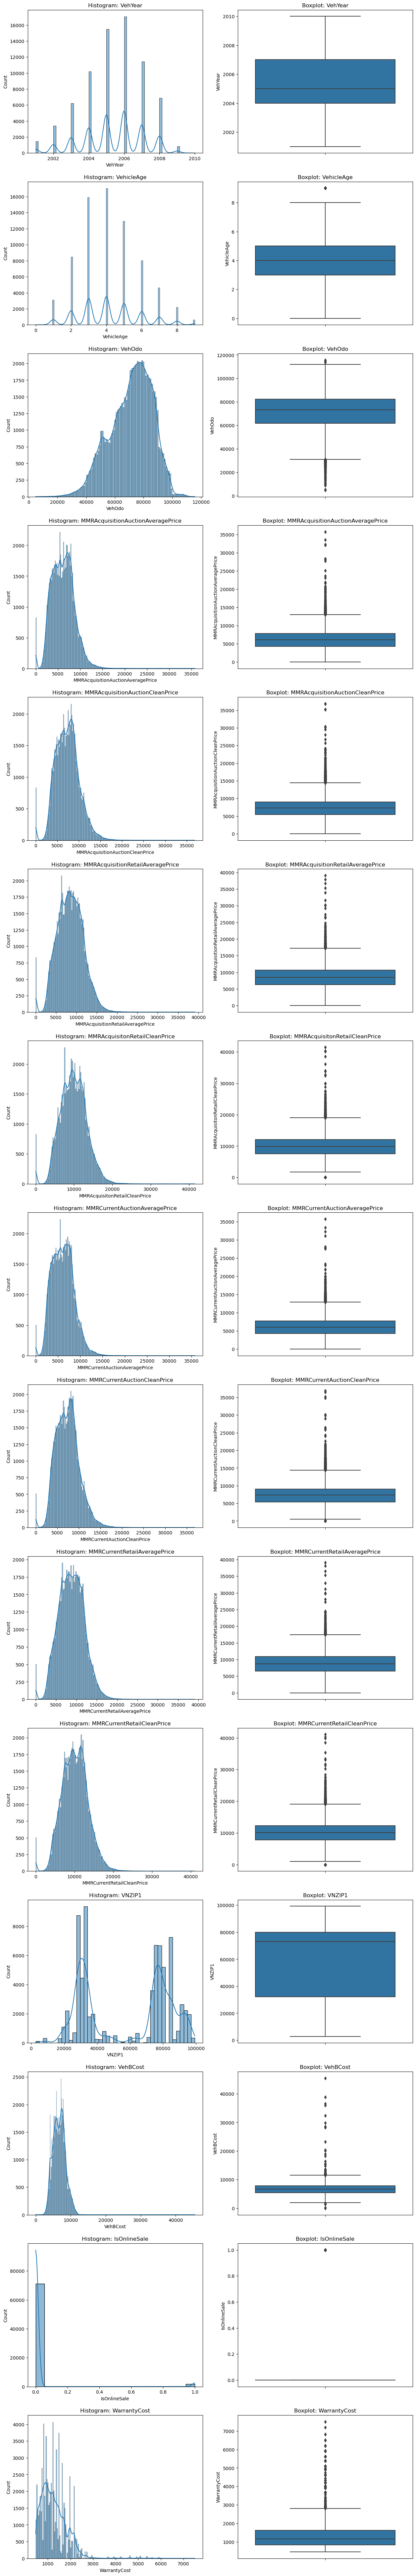

In [32]:
fig = plt.figure(figsize = (15, 100))
ax = fig.subplots(15,2)
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=ax[i, 0], kde=True)
    ax[i, 0].set_title(f'Histogram: {col}')
    
    sns.boxplot(y=df[col], ax=ax[i, 1])
    ax[i, 1].set_title(f'Boxplot: {col}')
plt.show()

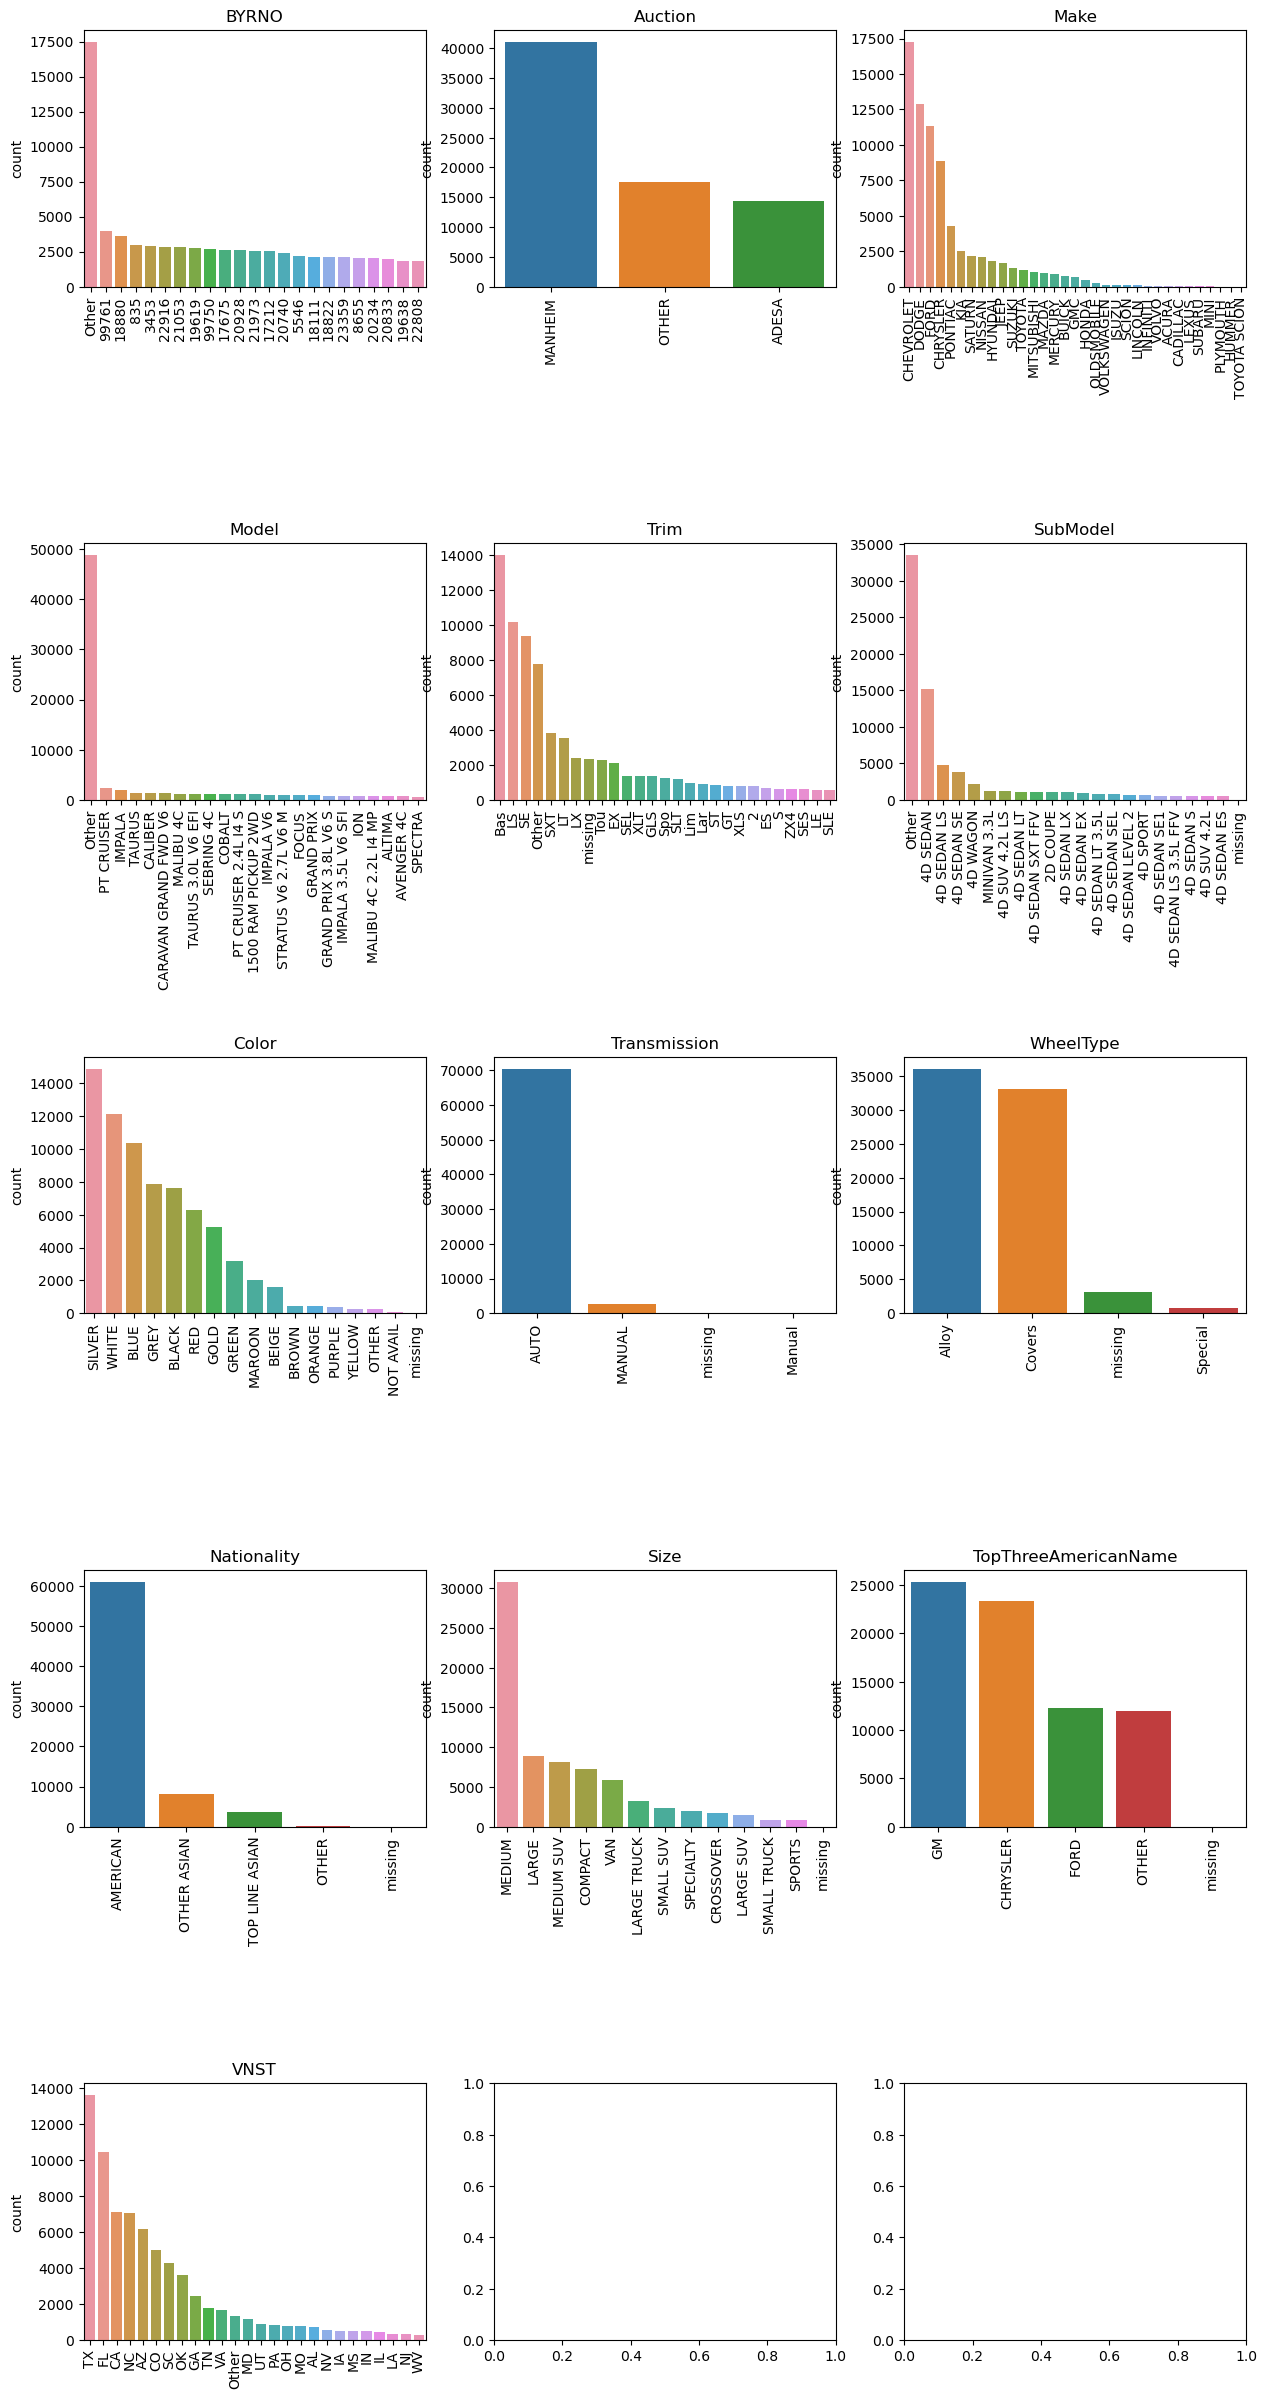

In [33]:
fig = plt.figure(figsize = (15, 30))
ax = fig.subplots(5,3).flatten()
for i, col in enumerate(ohe_cols):
    sns.countplot(x=col, data=df, ax=ax[i], order=df[col].value_counts().index)
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    ax[i].tick_params(axis='x', rotation=90)
plt.subplots_adjust(hspace=1)
plt.show()

In [34]:
num_cols.remove('IsOnlineSale')
bin_cols = ['IsOnlineSale']

In [35]:
preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), num_cols),
    ('bin','passthrough', bin_cols),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False), ohe_cols)
])

model_pipe = Pipeline(steps = [('preprocessor', preprocessor),
                               ('model', None)])

# Train LogisticRegression, GaussianNB, KNN from sklearn

Train LogisticRegression, GaussianNB, KNN from sklearn on the training dataset and check the quality of your algorithms on the validation dataset. The dependent variable (IsBadBuy) is binary. Don't forget to normalize your datasets before training your models.

In [36]:
X_processed = preprocessor.fit_transform(X_train)

print(f"Колонок на выходе: {X_processed.shape[1]}")
print(f"Строк: {X_processed.shape[0]}")

Колонок на выходе: 200
Строк: 24232


In [37]:
models = {'LogisticRegression': LogisticRegression(random_state=21),
          'KNeighbors': KNeighborsClassifier(),
          'GaussianNB': GaussianNB()}


for model_name, model in models.items():
    model_pipe.set_params(model=model)
    model_pipe.fit(X_train, y_train)
    predict = model_pipe.predict_proba(X_valid)[:, 1]
    gini_score = 2* roc_auc_score(y_valid, predict) -1
    print(model_name, gini_score)

LogisticRegression 0.47318982979647495
KNeighbors 0.19688326587136307
GaussianNB 0.07367682274886489


Лучше всего работает LogisticRegression тк она имеет встроенную регуляризацию

# Implement Gini score calculation

You can use 2ROC AUC - 1 approach, so you need to implement ROC AUC calculation. Check if your metric approximately equals abs(2\sklearn.metrcs.roc_auc_score - 1).

In [38]:
def my_roc_auc_score(y_true, y_pred_proba):
    indices = np.argsort(y_pred_proba)[::-1]
    y_true_sorted = np.array(y_true)[indices]
    n_pos = np.sum(y_true_sorted == 1)
    n_neg = np.sum(y_true_sorted == 0)
    if n_pos == 0 or n_neg == 0:
        return 0.5
    
   # рассчет tpr и fpr 
    tp = fp = 0
    tpr, fpr = [0], [0]
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)
        
    # площадь под кривой
    roc_auc = 0
    for i in range(1, len(fpr)):
        height = (tpr[i] + tpr[i-1]) /2
        width = fpr[i] - fpr[i-1]
        roc_auc += height * width
    return roc_auc

def my_gini(y_true, y_pred_proba):
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    return 2* roc_auc -1

In [39]:
print(f'My ROC AUC: {my_roc_auc_score(y_valid, predict)}')
print(f'Sklearn ROC AUC: {roc_auc_score(y_valid, predict)}')

My ROC AUC: 0.5219238795201594
Sklearn ROC AUC: 0.5368384113744324


# Implement your own versions of LogisticRegression, KNN and NaiveBayes classifiers

For LogisticRegression compute gradients with respect to the loss and use stochastic gradient descent. Can you reproduce the results from step 4?

In [40]:
class MyLogisticRegression():
    def __init__(self, learning_rate=0.001, n_iter=100, alpha=0.1):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.alpha = alpha

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0

        for _ in range(self.n_iter):
            z = np.dot(X, self.w) + self.b
            y_pred = 1 / (1 + np.exp(-z)) # сигмоида
            # считаем градиент
            gradient_w = (1 / X.shape[0]) * np.dot(X.T, (y_pred - y)) + self.alpha * self.w
            gradient_b = (1 / X.shape[0]) * np.sum(y_pred - y)
            # обновляем параметры
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b

    def predict_proba(self, X):
        z = np.dot(X, self.w) + self.b
        prob_class1 = 1 / (1 + np.exp(-z))
        prob_class0 = 1 - prob_class1
        return np.column_stack([prob_class0, prob_class1])

    def predict(self, X):
        return self.predict_proba(X) > 0.5

In [41]:
class MyKNN:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self
    
    def predict_proba(self, X):
        probabilities = []
        
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1)) # евклидово расстояние
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            class_counts = Counter(k_nearest_labels)
            total_neighbors = len(k_nearest_labels)
            # считаем вектор вероятностей
            unique_classes = np.unique(self.y_train)
            proba_vector = np.zeros(len(unique_classes))

            for i, cls in enumerate(unique_classes):
                proba_vector[i] = class_counts.get(cls, 0) / total_neighbors
                
            probabilities.append(proba_vector)
        return np.array(probabilities)
            
    def predict(self, X):
        probabilities = self.predict_proba(X)
        classes = np.unique(self.y_train)
        return classes[np.argmax(probabilities, axis=1)]

In [42]:
class MyGaussianNB:
    def __init__(self):
        self.class_probabilities = None
        self.feature_probabilities = None
        self.uniq_classes = None

    def fit(self, X, y):
        self.uniq_classes = np.unique(y)
        num_classes = len(self.uniq_classes)
        num_features = X.shape[1]

        self.class_probabilities = np.zeros(num_classes)
        self.feature_probabilities = np.zeros((num_classes, num_features))

        for i, c in enumerate(self.uniq_classes):
            X_c = X[y == c]
            self.class_probabilities[i] = X_c.shape[0] / len(X)
            self.feature_probabilities[i] = (np.sum(X_c, axis=0) + 1) / (X_c.shape[0] + 2)

    def predict_proba(self, X):
        num_samples = X.shape[0]
        count_classes = len(self.uniq_classes)

        predictions = np.zeros((num_samples, count_classes))

        for i in range(count_classes):
            class_probability = self.class_probabilities[i]
            feature_probability = self.feature_probabilities[i]
            log_likelihood = np.zeros(num_samples)
            for j in range(num_samples):
                likelihood = 1.0
                for k in range(len(feature_probability)):
                    if X[j, k] == 1:
                        likelihood *= feature_probability[k]
                    else:
                        likelihood *= (1 - feature_probability[k])

                predictions[j, i] = class_probability * likelihood
        return predictions / np.sum(predictions, axis=1, keepdims=True)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return self.uniq_classes[np.argmax(probabilities, axis=1)]

In [43]:
models = {'LogisticRegression': LogisticRegression(random_state=21),
          'MyLogisticRegression': MyLogisticRegression(),
          'KNeighbors': KNeighborsClassifier(),
          'MyKNeighbors': KNeighborsClassifier(),
          'GaussianNB': GaussianNB(),
          'MyGaussianNB': MyGaussianNB()}


for model_name, model in models.items():
    model_pipe.set_params(model=model)
    model_pipe.fit(X_train, y_train)
    predict = model_pipe.predict_proba(X_valid)[:, 1]
    print(model_name, my_gini(y_valid, predict))

LogisticRegression 0.47318982979647495
MyLogisticRegression 0.10080091064759933
KNeighbors 0.19688326587136307
MyKNeighbors 0.19688326587136307
GaussianNB 0.07367682274886489
MyGaussianNB 0.3710131577542104


# Try to create non-linear features

fractions: feature1/feature2
groupby features: df[‘categorical_feature’].map(df.groupby(‘categorical_feature’)[‘continious_feature’].mean())

In [44]:
X_train_new = X_train.copy()
X_valid_new = X_valid.copy()

In [45]:
X_train_new['fraction_feature'] = X_train['VehOdo'] / X_train['VehicleAge'].replace(0, np.nan)
X_train_new['fraction_feature2'] = X_train['MMRCurrentRetailAveragePrice'] / X_train['WarrantyCost'].replace(0, np.nan)
X_train_new['groupby1'] = X_train['Make'].map(X_train.groupby('Make')['MMRAcquisitionAuctionAveragePrice'].mean())
X_train_new['groupby2'] = X_train['Model'].map(X_train.groupby('Model')['MMRAcquisitionAuctionAveragePrice'].mean())

X_train_new = X_train_new.replace([np.inf, -np.inf], np.nan)
X_train_new['fraction_feature'] = X_train_new['fraction_feature'].fillna(X_train['VehOdo'].median())
X_train_new['fraction_feature2'] = X_train_new['fraction_feature2'].fillna(X_train['MMRCurrentRetailAveragePrice'].median())

In [46]:
X_valid_new['fraction_feature'] = X_valid['VehOdo'] / X_valid['VehicleAge'].replace(0, np.nan)
X_valid_new['fraction_feature2'] = X_valid['MMRCurrentRetailAveragePrice'] / X_valid['WarrantyCost'].replace(0, np.nan)
X_valid_new['groupby1'] = X_valid['Make'].map(X_valid.groupby('Make')['MMRAcquisitionAuctionAveragePrice'].mean())
X_valid_new['groupby2'] = X_valid['Model'].map(X_valid.groupby('Model')['MMRAcquisitionAuctionAveragePrice'].mean())

X_valid_new = X_valid_new.replace([np.inf, -np.inf], np.nan)
X_valid_new['fraction_feature'] = X_valid_new['fraction_feature'].fillna(X_valid['VehOdo'].median())
X_valid_new['fraction_feature2'] = X_valid_new['fraction_feature2'].fillna(X_valid['MMRCurrentRetailAveragePrice'].median())

In [47]:
num_cols.extend(['fraction_feature', 'fraction_feature2', 'groupby1', 'groupby2'])

In [48]:
for model_name, model in models.items():
    model_pipe.set_params(model=model)
    model_pipe.fit(X_train_new, y_train)
    predict = model_pipe.predict_proba(X_valid_new)[:, 1]
    print(model_name, my_gini(y_valid, predict))

LogisticRegression 0.4713487172732309
MyLogisticRegression 0.11557018714911793
KNeighbors 0.1968848233706777
MyKNeighbors 0.1968848233706777
GaussianNB 0.08018279405290385
MyGaussianNB 0.3710131577542104


In [49]:
for feature in ['fraction_feature', 'fraction_feature2', 'groupby1', 'groupby2']:
    num_cols.remove(feature)

# Determine the best features for the problem using the coefficients of the logistic model

Try to eliminate useless features by hand and by L1 regularization. Which approach is better in terms of Gini score?

In [50]:
model_pipe.set_params(model=LogisticRegression(solver='saga', class_weight='balanced', random_state=21))
model_pipe.fit(X_train, y_train)
predict = model_pipe.predict_proba(X_valid)[:, 1]
print(my_gini(y_valid, predict))

0.47207311762116166


## shap

In [51]:
model_pipe.set_params(model=LogisticRegression(solver='saga', class_weight='balanced', random_state=21))
model_pipe.fit(X_train, y_train)
X_train_processed = model_pipe.named_steps['preprocessor'].transform(X_train)
X_valid_processed = model_pipe.named_steps['preprocessor'].transform(X_valid)
feature_names = model_pipe.named_steps['preprocessor'].get_feature_names_out()
explainer = shap.Explainer(model_pipe.named_steps['model'], X_train_processed)
shap_values = explainer.shap_values(X_train_processed)
shap_importance = np.abs(shap_values).mean(axis=0)
selected_features = pd.DataFrame({
    'feature': feature_names, 
    'importance': shap_importance
}).sort_values('importance', ascending=False).head(21)['feature'].tolist()

In [52]:
selected_mask = [f in selected_features for f in feature_names]
X_train_selected = X_train_processed[:, selected_mask]
X_valid_selected = X_valid_processed[:, selected_mask]

model_selected= model_pipe.named_steps['model']
model_selected.fit(X_train_selected, y_train)
predict = model_selected.predict_proba(X_valid_selected)[:, 1]
print(my_gini(y_valid, predict))

0.47648179001467916


## L1

In [53]:
model_pipe.set_params(model=LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', random_state=21))
model_pipe.fit(X_train, y_train)
predict = model_pipe.predict_proba(X_valid)[:, 1]
print(my_gini(y_valid, predict))

0.4715476321857084


In [54]:
selected_features = model_pipe.named_steps['model'].coef_[0]
print(np.argsort(selected_features)[::-1])
print(sum(selected_features != 0))

[158  57  40  13   4 120   2 183  49  53 182  84 199   1  71 192 121 128
 132 189  51 134  95 113 187 125 157 176 198 194  54 178 117 133 136 140
 197 127 135   3 160 114 116 171 118 173  60 181  92  45  98 186 149 146
 184  91 103  18  37 123  80 110 143 167 141  15 104  56 138  16 144 177
 175 159  77 105  79  75  65  64  69   5  81  66  67  70  86  94  87  68
  89  61  74  59 185   6  29  41 122 150   9 126  43  10 131  11  47  14
  73 179  23  62 156 129  38 163 124  44 139  85 196  93  42  72  82  48
  99 142 102 151 161  52  39 145 166  33 170  97 162 112  83 119  96 115
 154 130  63   7  36  55  22 106 107 164  90 109 180 190 165 188  24 195
 174 101  31  28  17  27 168  20 172 169  19  26 100  58  25 193  30 152
  88  32 111 108  46 148 147   8  21  76  78 191   0 155 153 137  34  50
  35  12]
165


отобранные shap признаки показали лучшую точность но различие менее сотой

In [55]:
model_pipe_selected = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_select', FunctionTransformer(lambda X: X[:, selected_mask])),
    ('model', None)
])


# Select your best model (algorithm + feature set) and tweak its hyperparameters to increase the Gini score on the validation dataset

In [56]:
param_dist_logreg = {'model__C': np.logspace(-4, 4, 20),
                     'model__penalty': ['l1', 'l2', 'elasticnet'],
                     'model__solver': ['lbfgs', 'sag', 'saga'],
                     'model__l1_ratio': np.linspace(0, 1, 10),
                     'model__class_weight': [None, 'balanced'],
                     'model__max_iter': [500, 1000]}
logreg = LogisticRegression(random_state=21, n_jobs=-1)
model_pipe_selected.set_params(model=logreg)
logreg_rand = RandomizedSearchCV(estimator=model_pipe_selected, param_distributions=param_dist_logreg, scoring='roc_auc', cv=3, n_iter=25, n_jobs=-1, random_state=21)
logreg_rand.fit(X_train, y_train)
logreg_rand.best_params_

{'model__solver': 'lbfgs',
 'model__penalty': 'l2',
 'model__max_iter': 500,
 'model__l1_ratio': 0.5555555555555556,
 'model__class_weight': 'balanced',
 'model__C': 10000.0}

In [57]:
best_logreg = logreg_rand.best_estimator_
predict = best_logreg.predict_proba(X_valid)[:, 1]
print(my_gini(y_valid, predict))

0.47621544279853834


In [58]:
search_results = pd.DataFrame(logreg_rand.cv_results_)
search_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__penalty,param_model__max_iter,param_model__l1_ratio,param_model__class_weight,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.158242,0.040465,0.023027,0.032565,lbfgs,l2,500,0.555556,balanced,10000.000000,"{'model__solver': 'lbfgs', 'model__penalty': '...",NaN,NaN,0.732864,NaN,NaN,1
22,0.135264,0.002432,0.000000,0.000000,lbfgs,l1,500,0.222222,None,0.233572,"{'model__solver': 'lbfgs', 'model__penalty': '...",NaN,NaN,NaN,NaN,NaN,1
21,0.139957,0.017261,0.000000,0.000000,sag,elasticnet,1000,0.333333,None,0.615848,"{'model__solver': 'sag', 'model__penalty': 'el...",NaN,NaN,NaN,NaN,NaN,1
20,0.171540,0.058518,0.024268,0.034320,lbfgs,l2,1000,0.000000,balanced,0.033598,"{'model__solver': 'lbfgs', 'model__penalty': '...",NaN,NaN,0.740843,NaN,NaN,1
19,0.214424,0.120675,0.029055,0.041089,saga,l1,500,0.888889,None,1438.449888,"{'model__solver': 'saga', 'model__penalty': 'l...",NaN,NaN,0.727930,NaN,NaN,1


In [59]:
param_penalty = search_results.groupby(['param_model__penalty']).agg({'mean_test_score': 'mean', 'std_test_score': 'mean'})
param_penalty

,mean_test_score,std_test_score
param_model__penalty,,
elasticnet,NaN,NaN
l1,NaN,NaN
l2,NaN,NaN


In [60]:
def objective(trial):
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    if penalty == 'l1':
        solver = 'saga' 
    elif penalty == 'elasticnet':
        solver = 'saga'
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    else:
        solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'saga'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 500, 3000)
    logreg_params = {'C': C,
                     'penalty': penalty,
                     'solver': solver,
                     'class_weight': class_weight,
                     'max_iter': max_iter,
                     'random_state': 21,
                     'n_jobs': -1}
    try:
        logreg = LogisticRegression(**logreg_params)
        model_pipe_selected.set_params(model=logreg)
        model_pipe_selected.fit(X_train, y_train)
        y_pred = model_pipe_selected.predict_proba(X_valid)[:, 1]
        gini= my_gini(y_valid, y_pred)
        return gini
    except Exception as e:
        return 0.0

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(study.best_params)
print(f"Лучшее gini: {study.best_value:.4f}")

[I 2025-11-13 01:43:40,687] A new study created in memory with name: no-name-3d7e43d6-f5ab-4011-bce9-aa0cf79a9a98


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-13 01:43:47,451] Trial 0 finished with value: 0.461040623142126 and parameters: {'C': 17.398370285647363, 'penalty': 'l1', 'class_weight': None, 'max_iter': 847}. Best is trial 0 with value: 0.461040623142126.
[I 2025-11-13 01:43:48,810] Trial 1 finished with value: 0.4762152647986171 and parameters: {'C': 4621.672969903562, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'max_iter': 2022}. Best is trial 1 with value: 0.4762152647986171.
[I 2025-11-13 01:43:49,194] Trial 2 finished with value: 0.4583689036510157 and parameters: {'C': 0.0014689442993409709, 'penalty': 'l2', 'solver': 'sag', 'class_weight': 'balanced', 'max_iter': 1689}. Best is trial 1 with value: 0.4762152647986171.
[I 2025-11-13 01:43:49,479] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0002132777904387694, 'penalty': 'l1', 'class_weight': None, 'max_iter': 2037}. Best is trial 1 with value: 0.4762152647986171.
[I 2025-11-13 01:43:49,616] Trial 4 finished with value: 0.0 and para

Most impactfull:
For logistic regression - regularization scale
For naive bayes - the distribution
For KNN - metric for distance calculation, number of neighbors and the way how we assign weights to the neighbors.
For SVM - kernel function and regularization scale

# Check the Gini scores on all three datasets for your best model

training Gini, valid Gini, test Gini. Do you see a drop in performance when comparing the valid quality to the test quality? Is your model overfitted or not? Explain.

In [61]:
best_model = LogisticRegression(**study.best_params)
logreg = LogisticRegression(**study.best_params)
model_pipe_selected.set_params(model=best_model)
model_pipe_selected.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('feature_select', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [62]:
y_tr_pred = model_pipe_selected.predict_proba(X_train)[:, 1]
gini_tr = my_gini(y_train, y_tr_pred)
print(f'Train gini: {gini_tr}')

y_val_pred = model_pipe_selected.predict_proba(X_valid)[:, 1]
gini_val = my_gini(y_valid, y_val_pred)
print(f'Valid gini: {gini_val}')

y_test_pred = model_pipe_selected.predict_proba(X_test)[:, 1]
gini_test = my_gini(y_test, y_test_pred)
print(f'Test gini: {gini_test}')

Train gini: 0.5081803401083422
Valid gini: 0.4762155317984993
Test gini: 0.5083229175474675


Модель стабильна на всех выборках, результаты близки к друг другу, модель не смотря на сильный дисбаланс целевой переменной работает хорошо

# Implement calculation of Recall, Precision, F1 score and AUC PR metrics.

Compare your algorithms on the test dataset using AUC PR metric.

In [63]:
def calculate_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    auc_pr = None
    print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')
    
def auc_pr(y_true, y_pred_proba):
    proba_idx = np.argsort(-np.array(y_pred_proba))
    y_true = np.array(y_true)[proba_idx]
    y_pred_proba = np.array(y_pred_proba)[proba_idx]
    TP = np.cumsum((y_true == 1))
    FP = np.cumsum((y_true == 0))
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (np.sum(y_true == 1) + 1e-10)
    precision = np.concatenate(([1], precision))
    recall = np.concatenate(([0], recall))
    auc_pr = np.trapz(precision, recall)
    return auc_pr

In [64]:
y_val_pred = model_pipe_selected.predict(X_valid)
calculate_metrics(y_valid, y_val_pred)
print(f'Precision: {precision_score(y_valid, y_val_pred)}, Recall: {recall_score(y_valid, y_val_pred)}, F1: {f1_score(y_valid, y_val_pred)}')

Precision: 0.30650329877473503, Recall: 0.5122873345935567, F1: 0.38353579431535834
Precision: 0.3065032987747408, Recall: 0.5122873345935728, F1: 0.3835357943153674


In [65]:
y_tst_pred = model_pipe_selected.predict(X_test)
calculate_metrics(y_test, y_tst_pred)
print(f'Precision: {precision_score(y_test, y_tst_pred)}, Recall: {recall_score(y_test, y_tst_pred)}, F1: {f1_score(y_test, y_tst_pred)}')

Precision: 0.2957998212689849, Recall: 0.5481947664789484, F1: 0.38425818435104747
Precision: 0.2957998212689902, Recall: 0.5481947664789666, F1: 0.3842581843510564


In [66]:
custom_auc_pr = auc_pr(y_test, y_test_pred)
sklearn_auc_pr = average_precision_score(y_test, y_test_pred)

print(f'\n=== AUC PR METRICS ===')
print(f'Custom AUC PR: {custom_auc_pr:.4f}')
print(f'Sklearn AUC PR: {sklearn_auc_pr:.4f}')


=== AUC PR METRICS ===
Custom AUC PR: 0.4571
Sklearn AUC PR: 0.4572


# Which hard label metric do you prefer for the task of detecting "lemon" cars?

Для такой задачи лучше использовать AUC ROC или AUC PR чтобы был баланс между отсеиванием хороших и нахождением плохих

In [67]:
print(classification_report(y_test, y_tst_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_tst_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     21318
           1       0.30      0.55      0.38      3019

    accuracy                           0.78     24337
   macro avg       0.61      0.68      0.63     24337
weighted avg       0.85      0.78      0.81     24337


Confusion Matrix:
[[17378  3940]
 [ 1364  1655]]
